<img align="left" src="https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/CC_BY.png"><br />

Adopted by Valdis Saulespurens from  [Nathan Kelber](http://nkelber.com) and Ted Lawless for [JSTOR Labs](https://labs.jstor.org/) under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/)<br />
For questions/comments/improvements, email valdis.s.coding at gmail com<br />
___

# Latent Dirichlet Allocation (LDA) Topic Modeling

**Description:**
This [notebook](https://docs.constellate.org/key-terms/#jupyter-notebook) demonstrates how to do topic modeling. The following processes are described:

* Filtering based on a [stop words list](https://docs.constellate.org/key-terms/#stop-words)
* Cleaning the tokens in the dataset
* Creating a [gensim dictionary](https://docs.constellate.org/key-terms/#gensim-dictionary)
* Creating a [gensim](https://docs.constellate.org/key-terms/#gensim) [bag of words](https://docs.constellate.org/key-terms/#bag-of-words) [corpus](https://docs.constellate.org/key-terms/#corpus)
* Computing a topic list using [gensim](https://docs.constellate.org/key-terms/#gensim)
* Visualizing the topic list with `pyldavis`

**Use Case:** For Researchers (Mostly code without explanation, not ideal for learners)

**Difficulty:** Intermediate

**Completion time:** 60 minutes

**Knowledge Required:** 
* Python Basics Series ([Start Python Basics I](./python-basics-1.ipynb))

**Knowledge Recommended:**
* [Exploring Metadata](./metadata.ipynb)
* [Working with Dataset Files](./working-with-dataset-files.ipynb)
* [Pandas I](./pandas-1.ipynb)
* [Creating a Stopwords List](./creating-stopwords-list.ipynb)
* A familiarity with [gensim](https://docs.constellate.org/key-terms/#gensim) is helpful but not required.

**Data Format:** [JSON Lines (.jsonl)](https://docs.constellate.org/key-terms/#jsonl)

**Libraries Used:**

* [pandas](https://constellate.org/docs/key-terms/#pandas) to load a preprocessing list
* `csv` to load a custom stopwords list
* [gensim](https://docs.constellate.org/key-terms/#gensim) to accomplish the topic modeling
* [NLTK](https://docs.constellate.org/key-terms/#nltk) to create a stopwords list (if no list is supplied)
* `pyldavis` to visualize our topic model

**Research Pipeline**
1. Build a dataset
2. Create a "Pre-Processing CSV" with [Exploring Metadata](./exploring-metadata.ipynb) (Optional)
3. Create a "Custom Stopwords List" with [Creating a Stopwords List](./creating-stopwords-list.ipynb) (Optional)
4. Complete the Topic Modeling analysis with this notebook
____

## What is Topic Modeling?

**Topic modeling** is a **machine learning** technique that attempts to discover groupings of words (called topics) that commonly occur together in a body of texts. The body of texts could be anything from journal articles to newspaper articles to tweets.

**Topic modeling** is an unsupervised, clustering technique for text. We give the machine a series of texts that it then attempts to cluster the texts into a given number of topics. There is also a *supervised*, clustering technique called **Topic Classification**, where we supply the machine with examples of pre-labeled topics and then see if the machine can identify them given the examples.

**Topic modeling** is usually considered an exploratory technique; it helps us discover new patterns within a set of texts. **Topic Classification**, using labeled data, is intended to be a predictive technique; we want it to find more things like the examples we give it.

<font color='red'>Read more</font>

* ["Latent Dirichlet Allocation: Intuition, math, implementation and visualisation with pyLDAvis" Ioana](https://towardsdatascience.com/latent-dirichlet-allocation-intuition-math-implementation-and-visualisation-63ccb616e094) 2020
* ["Latent Dirichlet Allocation" Blei, Ng, Jordan](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf?TB_iframe=true&width=370.8&height=658.8) 2003

## Import your dataset

In [ ]:

import pandas
import os
import gensim
import requests


In [ ]:
pandas.__version__

'1.3.5'

In [ ]:
gensim.__version__

'3.6.0'

In [ ]:
url = "https://github.com/ValRCS/BSSDH_22/raw/main/corpora/lv_old_newspapers_5k.tsv"

df = pandas.read_csv(url, sep="\t") 
df.head()

,Language,Source,Date,Text
0,Latvian,rekurzeme.lv,2008/09/04,"""Viņa pirmsnāves zīmītē bija rakstīts vienīgi ..."
1,Latvian,diena.lv,2012/01/10,info@zurnalistiem.lv
2,Latvian,bauskasdzive.lv,2007/12/27,"Bhuto, kas Pakistānā no trimdas atgriezās tika..."
3,Latvian,bauskasdzive.lv,2008/10/08,Plkst. 4.00 Samoilovs / Pļaviņš (pludmales vol...
4,Latvian,diena.lv,2011/10/05,"CVK bija vērsusies Skaburska, lūdzot izskaidro..."


In [ ]:
full_url = "https://github.com/ValRCS/BSSDH_22/raw/main/corpora/lv_old_newspapers.zip"
# so Estonian one is "https://github.com/ValRCS/BSSDH_22/raw/main/corpora/ee_old_newspapers.zip"
# Ukranian "https://github.com/ValRCS/BSSDH_22/raw/main/corpora/ua_old_newspapers.zip"
full_df = pandas.read_csv(full_url, sep="\t", compression="zip")
full_df.shape

(319428, 4)

In [ ]:
raw_documents = list(df.Text)
len(raw_documents) # we will use each document separately so again we have a list of strings so far

4999

In [ ]:
type(raw_documents)

list

In [ ]:
type(raw_documents[0]) # each document is a string so far

str

## Load Stopwords List

If you have created a stopword list in the stopwords notebook, we will import it here. (You can always modify the CSV file to add or subtract words then reload the list.) Otherwise, we'll load the NLTK [stopwords](https://docs.constellate.org/key-terms/#stop-words) list automatically.

In [ ]:
# how to find all languages stopwords built in NLTK
# https://stackoverflow.com/questions/54573853/nltk-available-languages-for-stopwords
# bigger collection of all stopwords
# https://github.com/stopwords-iso
# latvian https://github.com/stopwords-iso/stopwords-lv/raw/master/stopwords-lv.txt
url = "https://github.com/stopwords-iso/stopwords-lv/raw/master/stopwords-lv.txt"
stop_words = []
response = requests.get(url)
if response.status_code == 200:
    stop_words = response.text.split()
len(stop_words), stop_words[:5]
# see previous session on how to save locally your stopwords

(161, ['aiz', 'ap', 'apakš', 'apakšpus', 'ar'])

## Define a Function to Process Tokens
Next, we create a short function to clean up our tokens.

In [ ]:
def process_token(token):
    token = token.lower()
    if token in stop_words:
        return # return None
    if len(token) < 4:
        return
    if not token.isalpha(): # if we hav any non alphabethic then we return nothing
        return
    return token

In [ ]:
"Valdis".isalpha()

True

In [ ]:
"Valdis34".isalpha()

False

In [ ]:
process_token("Valdis")

'valdis'

In [ ]:
process_token("Valdis324")

In [ ]:
# %%time
# Limit to n documents. Set to None to use all documents.

documents = [] # start with a blank list of documents
for document in raw_documents:
    # so we get tokens out of each individual document
    tokens = document.split() # here you could modify to use nltk.word_tokenize
    # we create a list of processed tokens for each document
    processed_document = [process_token(token) for token in tokens if process_token(token) is not None] # TODO could be improved with new walrus :=
    documents.append(processed_document)
print(f'Converted all documents to list of clean tokens')
documents[:3]

Converted all documents to list of clean tokens


[['pirmsnāves',
  'zīmītē',
  'rakstīts',
  'vienīgi',
  'smēķēšanas',
  'aizlieguma',
  'radītajiem',
  'laikrakstam',
  'paskaidroja',
  'nelaiķa',
  'svainis',
  'helmuts',
  'nebija',
  'vērsta',
  'viņa',
  'ģimeni'],
 [],
 ['pakistānā',
  'trimdas',
  'atgriezās',
  'diviem',
  'uzstājās',
  'priekšvēlēšanu',
  'organizēts',
  'nākamajā',
  'mēnesī',
  'gaidāmajām',
  'parlamenta']]

In [ ]:
documents[-2:] # lets check last two documents

[['vairāki',
  'pasākumi',
  'veltīti',
  'jaunākajiem',
  'lasītājiem',
  'šodien',
  'apgāds',
  'rīko',
  'gada',
  'rakstnieki',
  'oficiālo',
  'pasludināšanu',
  'notiks',
  'antoloģijas',
  'skaitāmi',
  'atvēršanas',
  'sestdien',
  'baudīt',
  'māra',
  'putniņa',
  'stāstus',
  'romānā',
  'atdzīvinātajiem',
  'ēdamajiem',
  'svētdien',
  'risināsies',
  'latvijas',
  'bērnu',
  'žūrijas',
  'lielie',
  'lasīšanas',
  'sveikti',
  'populārākie',
  'bērnu',
  'grāmatu',
  'tulkotāji'],
 ['piecu',
  'stundu',
  'pavadīšanas',
  'taškentas',
  'lidostas',
  'uzgaidāmajā',
  'telpā',
  'nakts',
  'lidmašīnā',
  'citā',
  'izkāpjot',
  'lidmašīnas',
  'sajūtams',
  'taizemi',
  'brauc',
  'vairums',
  'ziemeļvalstīs']]

Build a gensim dictionary corpus and then train the model. More information about parameters can be found at the [Gensim LDA Model page](https://radimrehurek.com/gensim/models/ldamodel.html).

In [ ]:
dictionary = gensim.corpora.Dictionary(documents)

In [ ]:
len(dictionary)

31687

In [ ]:
# so dictionary is just a mapping of ids to tokens - because ML algorithms most often work with numbers
list(dictionary.items())[:10]

[(0, 'aizlieguma'),
 (1, 'helmuts'),
 (2, 'laikrakstam'),
 (3, 'nebija'),
 (4, 'nelaiķa'),
 (5, 'paskaidroja'),
 (6, 'pirmsnāves'),
 (7, 'radītajiem'),
 (8, 'rakstīts'),
 (9, 'smēķēšanas')]

In [ ]:
doc_count = len(documents)
num_topics = 7 # Change the number of topics 7 is just a wild guess here
passes = 5 # The number of passes used to train the model
# By default: Remove terms that appear in less than 5 documents and terms that occur in more than 90% of documents.
dictionary.filter_extremes()

In [ ]:
single_bow = dictionary.doc2bow(documents[0])
single_bow

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1)]

In [ ]:
last_bow = dictionary.doc2bow(documents[-1])
last_bow


[(1296, 1),
 (1778, 1),
 (1786, 1),
 (4857, 1),
 (6202, 1),
 (6330, 1),
 (6764, 1),
 (9817, 1),
 (10769, 1),
 (17773, 1),
 (24955, 1),
 (31681, 1),
 (31682, 1),
 (31683, 1),
 (31684, 1),
 (31685, 1),
 (31686, 1)]

In [ ]:
dictionary[1296],dictionary[1778],dictionary[31686]

('stundu', 'piecu', 'ziemeļvalstīs')

In [ ]:
documents[-1]

['piecu',
 'stundu',
 'pavadīšanas',
 'taškentas',
 'lidostas',
 'uzgaidāmajā',
 'telpā',
 'nakts',
 'lidmašīnā',
 'citā',
 'izkāpjot',
 'lidmašīnas',
 'sajūtams',
 'taizemi',
 'brauc',
 'vairums',
 'ziemeļvalstīs']

In [ ]:
documents[-1]

['piecu',
 'stundu',
 'pavadīšanas',
 'taškentas',
 'lidostas',
 'uzgaidāmajā',
 'telpā',
 'nakts',
 'lidmašīnā',
 'citā',
 'izkāpjot',
 'lidmašīnas',
 'sajūtams',
 'taizemi',
 'brauc',
 'vairums',
 'ziemeļvalstīs']

In [ ]:
# now we are going to generated a bag of words for each document
# we are creating a list of bag of words 
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]

In [ ]:
# this code does the same thing (slightly slower) than the above one line
bow_corpus = []
for doc in documents:
    bow = dictionary.doc2bow(doc)
    bow_corpus.append(bow)

In [ ]:
%%time
# %%time is a jupyter so called magic command which times your cell
# Train the LDA model
model = gensim.models.LdaModel(
    corpus=bow_corpus, # so list of bag of words
    id2word=dictionary,# so dictionary mapping ids to words
    num_topics=num_topics, # so called hyper parameter which we can adjust
    passes=passes # for optimization no need to run toomuch 5 is a good starting compromise
)

CPU times: user 8.87 s, sys: 213 ms, total: 9.09 s
Wall time: 8.87 s


## Perplexity

After each pass, the LDA model will output a "perplexity" score that measures the "held out log-likelihood". Perplexity is a measure of how "surpised" the machine is to see certain data. In other words, perplexity measures how successfully a trained topic model predicts new data. The model may be trained many times with different parameters, optimizing for the lowest possible perplexity.

In general, the perplexity score should trend downward as the machine "learns" what to expect from the data. While a low perplexity score may signal the machine has learned the documents' patterns, that does not mean that the topics formed from a model with low perplexity will form the most coherent topics. (See ["Reading Tea Leaves: How Humans Interpret Topic Models" Chang, et al. 2009](https://papers.nips.cc/paper/2009/hash/f92586a25bb3145facd64ab20fd554ff-Abstract.html).)



## Topic Coherence

The failure of perplexity scores to consistently create "good" topics has led to new methods in "topic coherence". Here we demonstrate two of these methods with Gensim but there are additional methods available. Ideally, a researcher would run many topic models, discovering the optimum settings for topic coherence.

Ultimately, however, the best judgment of topic coherence is a disciplinary expert, particularly someone with familiarity with the materials in question.

<font color='red'>Read more</font>

* ["Optimizing Semantic Coherence in Topic Models" Mimno, et al. 2011](http://dirichlet.net/pdf/mimno11optimizing.pdf)
* ["Automatic Evaluation of Topic Coherence" Newman, et al. 2010](https://mimno.infosci.cornell.edu/info6150/readings/N10-1012.pdf))


In [ ]:
# Compute the coherence score using UMass
# u_mass is measured from -14 to 14, higher is better
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(
    model=model,
    corpus=bow_corpus,
    dictionary=dictionary, 
    coherence='u_mass'
)

# Compute Coherence Score using UMass
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -4.75814787728133


## Display a List of Topics
Print the most significant terms, as determined by the model, for each topic.

In [ ]:
num_topics

7

In [ ]:
model.get_topic_terms(0) #  you can adjust topn to see more or less than default 10 terms

[(59, 0.01357901),
 (4, 0.009470687),
 (58, 0.00822398),
 (14, 0.007737055),
 (451, 0.007566931),
 (84, 0.0064007454),
 (146, 0.00633214),
 (56, 0.0058322484),
 (567, 0.0056131748),
 (350, 0.0053895665)]

In [ ]:
dictionary[59], dictionary[350]

('viņš', 'kuri')

In [ ]:
for topic_num in range(0, num_topics): # so this loop goes from 0 to 6 (since 7 is not included in range)
    word_ids = model.get_topic_terms(topic_num)
    words = []
    for wid, weight in word_ids:
        word = dictionary.id2token[wid]
        words.append(word)
    print("Topic {}".format(str(topic_num).ljust(5)), " ".join(words))

Topic 0     viņš viņa viņi latvijas ļoti savu gadā visu tagad kuri
Topic 1     gada eiropas šogad latvijas darba latvijā valsts pagasta savu šajā
Topic 2     latvijas viņa vairāk eiropas savukārt laikā lielu ļoti pirmā komandas
Topic 3     rīgas novada policijas domes latu savukārt eiro gada pārvaldes varētu
Topic 4     valsts izglītības kultūras mākslas latvijas skolas jēkabpils bērnu novada darba
Topic 5     latvijas daudz mājas ļoti mums gadā gadus laikā vismaz savukārt
Topic 6     valsts darba gada mūsu kuriem būtu varētu šādu viņš kopumā


## Visualize the Topic Distances

Visualize the model using [`pyLDAvis`](https://pyldavis.readthedocs.io/en/latest/). This visualization can take a while to generate depending on the size of your dataset.

Try choosing a topic and adjusting the λ slider. When λ approaches 0, the words in a given document occur almost entirely in that topic. When λ approaches 1, the words occur more often in other topics.

In [ ]:
# most likely we do not have pyLDAvis visualization library so we will install it
!pip install pyLDAvis

In [3]:
# later versions pyLDAvis do not play well with colab
# https://stackoverflow.com/questions/66096149/pyldavis-visualization-from-gensim-not-displaying-the-result-in-google-colab

In [ ]:
import pyLDAvis
# you can try installing an older version
# !pip install pyLDAvis==2.1.2

In [ ]:
pyLDAvis.__version__

In [ ]:
# import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
# model is our LDA model
# bow_corpus is our list of bag of words for each document
# again dictionary is our mapping of ids to actual words 
lda_viz = gensimvis.prepare(model, bow_corpus, dictionary)


In [ ]:
# Export this visualization as an HTML file
# An internet connection is still required to view the HTML
p = gensimvis.prepare(model, bow_corpus, dictionary)
pyLDAvis.save_html(p, 'my_visualization.html')
# there are other options such as save_json and some other ones

In [ ]:
type(p)

In [ ]:
p # so you can in fact run inside colab

In [ ]:
# lets try creating a model with 10 topics
model_10 = gensim.models.LdaModel(
    corpus=bow_corpus, # so list of bag of words
    id2word=dictionary,# so dictionary mapping ids to words
    num_topics=10, # so called hyper parameter which we can adjust
    passes=passes # for optimization no need to run toomuch 5 is a good starting compromise
)

In [ ]:
coherence_model_lda_10 = CoherenceModel(
    model=model_10,
    corpus=bow_corpus,
    dictionary=dictionary, 
    coherence='u_mass'
)

# Compute Coherence Score using UMass
coherence_lda_10 = coherence_model_lda_10.get_coherence()
print('\nCoherence Score: ', coherence_lda_10)

In [ ]:
model_20 = gensim.models.LdaModel(
    corpus=bow_corpus, # so list of bag of words
    id2word=dictionary,# so dictionary mapping ids to words
    num_topics=20, # so called hyper parameter which we can adjust
    passes=passes # for optimization no need to run toomuch 5 is a good starting compromise
)

In [ ]:
model_5 = gensim.models.LdaModel(
    corpus=bow_corpus, # so list of bag of words
    id2word=dictionary,# so dictionary mapping ids to words
    num_topics=5, # so called hyper parameter which we can adjust
    passes=passes # for optimization no need to run toomuch 5 is a good starting compromise
)

## Prepare a topic model on your own corpus

In [1]:
from collections import Counter
import os
import pandas
import requests

In [6]:
url_ua = "https://github.com/ValRCS/BSSDH_22/raw/main/corpora/ua_old_newspapers.zip"

df_ua = pandas.read_csv(url_ua, sep="\t", compression="zip") 
df_ua.head()

,Language,Source,Date,Text
0,Ukranian,pravda.com.ua,2011/07/18,"Віце-прем'єр Борис Колесніков заявляє, що всі ..."
1,Ukranian,lviv.ua,2011/03/03,28-й тур (07.05)
2,Ukranian,zaxid.net,2011/06/16,"Як повідомлялося, Україна на теренах СНД є одн..."
3,Ukranian,unian.net,2011/08/04,"Як передає кореспондент УНІАН, за ухвалення ві..."
4,Ukranian,lvivpost.net,2009/05/19,"""Серцево-судинні захворювання займають перше м..."


In [7]:
df_ua.shape

(306617, 4)

In [8]:
!pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=a1d1f68f93fd3878d2af536c74c6a62be58294b5e982ea202f72423512395050
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.fileids())

['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
#url='https://github.com/Alir3z4/stop-words/blob/bd8cc1434faeb3449735ed570a4a392ab5d35291/ukrainian.txt'
from stop_words import get_stop_words
stop_words = get_stop_words('ukrainian')

In [15]:
type(stop_words)

list

In [18]:
stop_words[:5]

['a', 'б', 'в', 'г', 'е']

In [19]:
len(stop_words)

385

In [21]:
df_ua.head(2)

,Language,Source,Date,Text
0,Ukranian,pravda.com.ua,2011/07/18,"Віце-прем'єр Борис Колесніков заявляє, що всі ..."
1,Ukranian,lviv.ua,2011/03/03,28-й тур (07.05)


In [22]:
documents = list(df_ua.Text)
len(documents)

306617

In [24]:
text = "\n".join(documents)
len(text)

79328276

In [25]:
text_lower = text.lower()
len(text_lower)

79328276

In [26]:
tokens = text_lower.split()  # here major alternative would nltk's word_tokenize
# with .split() our foo, and foo. and foo will be different tokens
len(tokens)

11316246

In [27]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
#tokens = nltk.word_tokenize(text_lower)
#len(tokens)

In [29]:
type(tokens)

list

In [31]:
type(tokens[0])

str

In [32]:
"." in tokens

True

In [33]:
#some extra cleanup we want to get rid of 
words = [token for token in tokens if token.isalnum()] # so called list comprehension 
# we loop through tokens and filter out items using our if statement
len(words)

8780310

In [49]:
'!'.isalnum()

False

In [ ]:
'а'.

In [34]:
words[:10]

['борис',
 'колесніков',
 'що',
 'всі',
 'операції',
 'по',
 'будівництву',
 'в',
 'рамках',
 'проходять']

In [52]:
'а' in stop_words # ua


False

In [58]:
'й' in stop_words # ua

False

In [53]:
'a' in stop_words # en

True

In [60]:
stop_words[:20]

['а',
 'б',
 'в',
 'г',
 'е',
 'ж',
 'з',
 'м',
 'т',
 'у',
 'я',
 'є',
 'і',
 'аж',
 'ви',
 'де',
 'до',
 'за',
 'зі',
 'ми']

In [63]:
stop_words[0]='а'
stop_words.append('й')
stop_words.append('із')

In [64]:
# we keep only those words that are not in our stop_word list
words_clean = [word for word in words if word not in stop_words]
len(words_clean)

5340245

In [65]:
words_clean[:10]

['борис',
 'колесніков',
 'всі',
 'операції',
 'будівництву',
 'рамках',
 'проходять',
 'тур',
 'україна',
 'теренах']

In [71]:
words_clean2 = [word2 for word2 in words_clean if word2.isalpha()]

In [69]:
'as'.isalpha()

True

In [72]:
word_frequency = Counter(words_clean2)
word_frequency.most_common(20)

[('україни', 20016),
 ('має', 13070),
 ('щодо', 11322),
 ('бо', 10774),
 ('всі', 9668),
 ('області', 8904),
 ('ради', 7862),
 ('львівської', 7616),
 ('україні', 7526),
 ('голова', 7231),
 ('рішення', 6756),
 ('мають', 6682),
 ('питання', 6628),
 ('управління', 6322),
 ('голови', 6205),
 ('серед', 6115),
 ('словами', 5999),
 ('президента', 5583),
 ('роботи', 5393),
 ('партії', 5320)]

In [73]:
for gram, count in word_frequency.most_common(25):
    print(gram.ljust(20), count)

україни              20016
має                  13070
щодо                 11322
бо                   10774
всі                  9668
області              8904
ради                 7862
львівської           7616
україні              7526
голова               7231
рішення              6756
мають                6682
питання              6628
управління           6322
голови               6205
серед                6115
словами              5999
президента           5583
роботи               5393
партії               5320
львові               5019
би                   4992
президент            4918
усі                  4819
уже                  4801


In [74]:
len(word_frequency.most_common())

285787

In [75]:
len(word_frequency.most_common())

285787

In [76]:
import csv # this is built into Python

with open('word_frequencies.csv', 'w', encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(['unigram', 'count']) # write header
    for gram, count in word_frequency.most_common():
        writer.writerow([gram, count]) # we go row by row and write data

In [77]:
from wordcloud import WordCloud
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

In [78]:
import urllib.request # this is built in library used by requests
download_url = 'https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/sample_cloud.png'
urllib.request.urlretrieve(download_url, 'sample_cloud.png')

('sample_cloud.png', <http.client.HTTPMessage at 0x7f84bae918d0>)

In [79]:
type(word_frequency)

collections.Counter

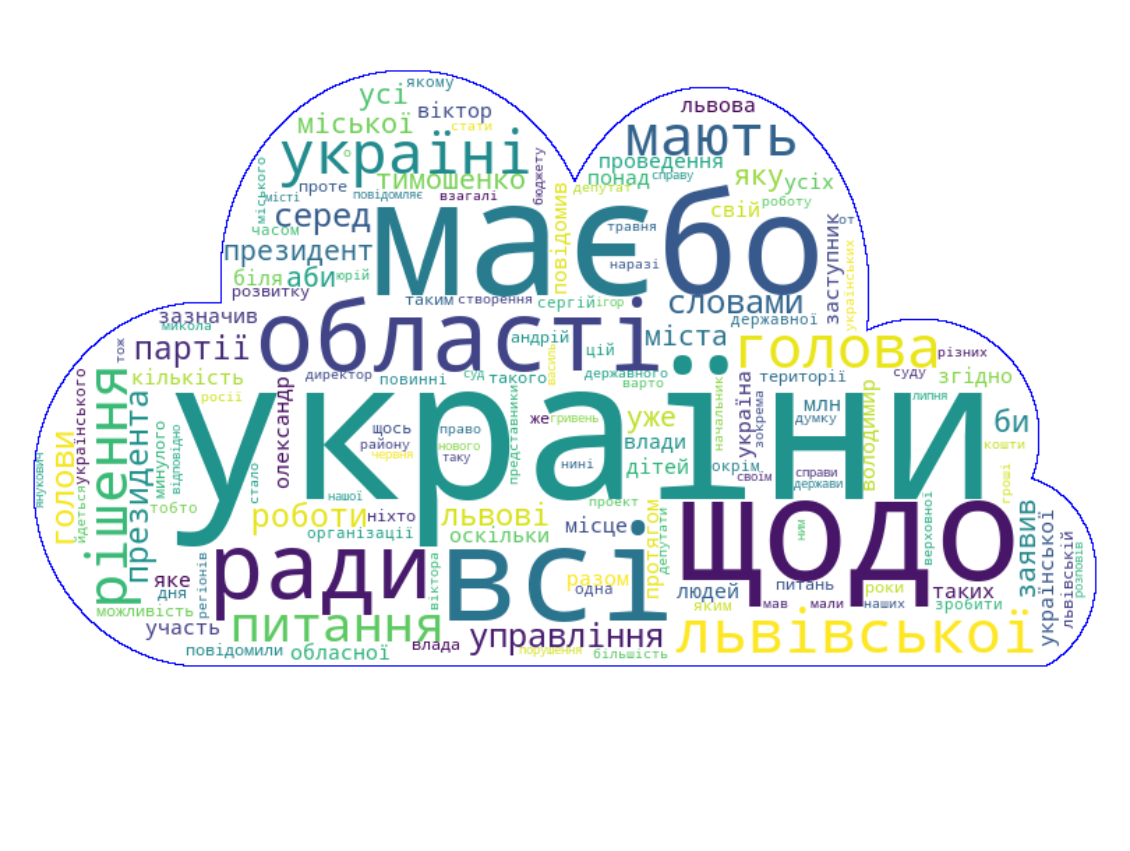

In [80]:
# Create a wordcloud from our data

# Adding a mask shape of a cloud to your word cloud
# By default, the shape will be a rectangle
# You can specify any shape you like based on an image file
cloud_mask = np.array(Image.open('sample_cloud.png')) # Specifies the location of the mask shape
cloud_mask = np.where(cloud_mask > 3, 255, cloud_mask) # this line will take all values greater than 3 and make them 255 (white)

### Specify word cloud details
wordcloud = WordCloud(
    width = 800, # Change the pixel width of the image if blurry
    height = 600, # Change the pixel height of the image if blurry
    background_color = "white", # Change the background color
    colormap = 'viridis', # The colors of the words, see https://matplotlib.org/stable/tutorials/colors/colormaps.html
    max_words = 150, # Change the max number of words shown
    min_font_size = 4, # Do not show small text
    
    # Add a shape and outline (known as a mask) to your wordcloud
    contour_color = 'blue', # The outline color of your mask shape
    mask = cloud_mask, # 
    contour_width = 1
).generate_from_frequencies(word_frequency) # so wordcloud is smart enought to use a counter object

# save wordcloud to file
wordcloud.to_file("my_wordcloud.png")
# alternative would be to right click save image as to save locally to your computer

mpl.rcParams['figure.figsize'] = (20,20) # Change the image size displayed
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [82]:
long_words = [word for word in words_clean2 if len(word) > 3] # so we want to only see long words
len(long_words)

4992554

In [83]:
long_word_frequency = Counter(long_words)
long_word_frequency.most_common(10)

[('україни', 20016),
 ('щодо', 11322),
 ('області', 8904),
 ('ради', 7862),
 ('львівської', 7616),
 ('україні', 7526),
 ('голова', 7231),
 ('рішення', 6756),
 ('мають', 6682),
 ('питання', 6628)]

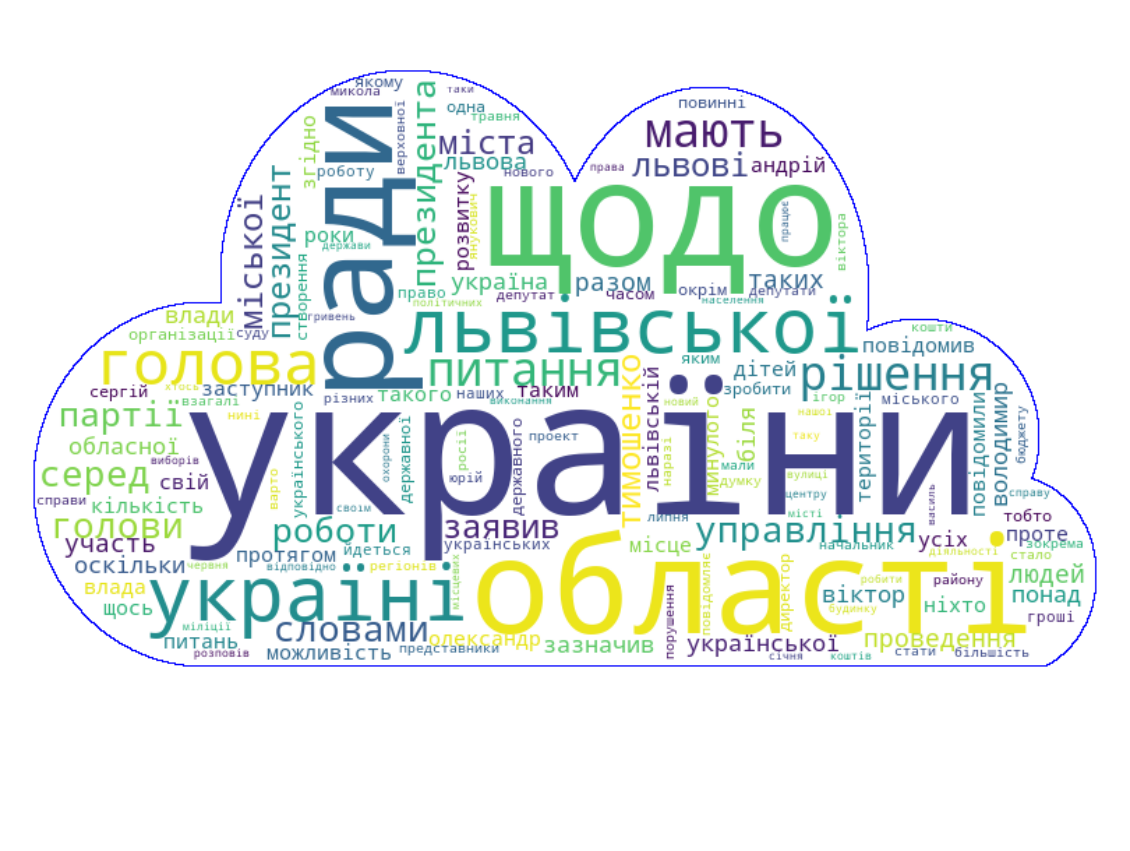

In [84]:
# Create a wordcloud from our data

# Adding a mask shape of a cloud to your word cloud
# By default, the shape will be a rectangle
# You can specify any shape you like based on an image file
cloud_mask = np.array(Image.open('sample_cloud.png')) # Specifies the location of the mask shape
cloud_mask = np.where(cloud_mask > 3, 255, cloud_mask) # this line will take all values greater than 3 and make them 255 (white)

### Specify word cloud details
wordcloud = WordCloud(
    width = 800, # Change the pixel width of the image if blurry
    height = 600, # Change the pixel height of the image if blurry
    background_color = "white", # Change the background color
    colormap = 'viridis', # The colors of the words, see https://matplotlib.org/stable/tutorials/colors/colormaps.html
    max_words = 150, # Change the max number of words shown
    min_font_size = 4, # Do not show small text
    
    # Add a shape and outline (known as a mask) to your wordcloud
    contour_color = 'blue', # The outline color of your mask shape
    mask = cloud_mask, # 
    contour_width = 1
).generate_from_frequencies(long_word_frequency) # so wordcloud is smart enought to use a counter object

# save wordcloud to file
wordcloud.to_file("wordcloud_length_4_or_Longer.png")
# alternative would be to right click save image as to save locally to your computer

mpl.rcParams['figure.figsize'] = (20,20) # Change the image size displayed
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [85]:
import plotly.graph_objects as go 

In [86]:
import plotly

In [87]:
plotly.__version__

'5.5.0'

In [88]:
# we will need to separate our frequency data into x axis - words
# y axis will be the frequency
# we start with two blank lists
X = [] # we could have used any name but X symbolizes array/list of x values
Y = []
max_count = 100
for x,y in word_frequency.most_common(max_count):
    X.append(x)
    Y.append(y)
# there are other methods for doing the above but this one is simple
X[:5],Y[:5]


(['україни', 'має', 'щодо', 'бо', 'всі'], [20016, 13070, 11322, 10774, 9668])

In [89]:
word_frequency.most_common(5)

[('україни', 20016),
 ('має', 13070),
 ('щодо', 11322),
 ('бо', 10774),
 ('всі', 9668)]

In [90]:
fig = go.Figure(data=[go.Scatter(
    x=X, y=Y,
    mode='markers') # there are other modes such as line mode or combined line+marker mode
])

fig.show()

In [91]:
sizes = [len(x) for x in X] # i go through all the words in X and generated a corresponding list of their lengths
sizes[:5]

[7, 3, 4, 2, 3]

In [92]:
# Utilize size in the plot
fig = go.Figure(data=[go.Scatter(
    x=X, y=Y,
    mode='markers',
    marker_size=sizes) # i could have also used a constant size here instead of a list of sizes
])

fig.show()

In [94]:
# if we are not happy with the size we can adjust it ad hoc - use your own judgment
big_sizes = [n*3 for n in sizes] # just for plotly
fig = go.Figure(data=[go.Scatter(
    x=X, y=Y,
    mode='markers',
    marker_size=big_sizes)
])

fig.show()

In [97]:
fig = go.Figure(data=[go.Scatter(
    x=X, y=Y,
    mode='markers',
    marker_size=big_sizes,
    #marker_color='red'
    marker_color='green'
    ) # so single color works
])

fig.show()

In [98]:
# we can assign custom colors for all 100 words 
# first we will take 4 colors and simply multiply / pad to have 100 colors - repeating every 4
colors = ['rgb(93, 164, 214)', 'rgb(255, 144, 14)','rgb(44, 160, 101)', 'rgb(255, 65, 54)'] * 25 # we need 100 colors
len(colors)

100

In [99]:
fig = go.Figure(data=[go.Scatter(
    x=X, y=Y,
    mode='markers',
    marker_size=big_sizes,
    marker_color=colors # determines colors, you could supply single color as well as string))
)])
fig.show()

In [107]:
def get_custom_color(word):
    return f"rgb({max(0, 180 - len(word) * 15)},  160, 101)"

In [109]:
custom_colors = [get_custom_color(w) for w in X]
custom_colors[:3]

['rgb(75,  160, 101)', 'rgb(135,  160, 101)', 'rgb(120,  160, 101)']

In [110]:
file_name = "ua_old_newspapers.zip"
# final bubbly chart with custom colors and sizes
fig = go.Figure(
    data=[go.Scatter(
    
    x=X, y=Y,
    mode='markers',
    marker_size=big_sizes,
    marker_color=custom_colors)
])
# example on how to add title , xaxis,yaxis, and custom font and sizes
fig.update_layout(
    title=f"Word frequency for {file_name}",
    xaxis_title="Words",
    yaxis_title="Frequency",
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [111]:
import pandas
import os
import gensim
import requests

In [112]:
df_ua.head()

,Language,Source,Date,Text
0,Ukranian,pravda.com.ua,2011/07/18,"Віце-прем'єр Борис Колесніков заявляє, що всі ..."
1,Ukranian,lviv.ua,2011/03/03,28-й тур (07.05)
2,Ukranian,zaxid.net,2011/06/16,"Як повідомлялося, Україна на теренах СНД є одн..."
3,Ukranian,unian.net,2011/08/04,"Як передає кореспондент УНІАН, за ухвалення ві..."
4,Ukranian,lvivpost.net,2009/05/19,"""Серцево-судинні захворювання займають перше м..."


In [113]:
raw_documents = list(df_ua.Text)
len(raw_documents)

306617

In [114]:
type(raw_documents)

list

In [115]:
type(raw_documents[0])

str

In [116]:
len(stop_words), stop_words[:5]

(390, ['а', 'б', 'в', 'г', 'е'])

In [117]:
def process_token(token):
    token = token.lower()
    if token in stop_words:
        return # return None
    if len(token) < 4:
        return
    if not token.isalpha(): # if we hav any non alphabethic then we return nothing
        return
    return token

In [118]:
documents = [] # start with a blank list of documents
for document in raw_documents:
    # so we get tokens out of each individual document
    tokens = document.split() # here you could modify to use nltk.word_tokenize
    # we create a list of processed tokens for each document
    processed_document = [process_token(token) for token in tokens if process_token(token) is not None] # TODO could be improved with new walrus :=
    documents.append(processed_document)
print(f'Converted all documents to list of clean tokens')
documents[:3]

Converted all documents to list of clean tokens


[['борис', 'колесніков', 'операції', 'будівництву', 'рамках', 'проходять'],
 [],
 ['україна',
  'теренах',
  'одним',
  'лідерів',
  'видавництва',
  'російськомовних',
  'загальний']]

In [119]:
documents[-2:] # lets check last two documents

[['серед',
  'наших',
  'ініціатив',
  'сприяння',
  'розробці',
  'національної',
  'політики',
  'щодо',
  'здорового',
  'способу',
  'інформування',
  'громадськості',
  'обмеження',
  'щодо',
  'продажу',
  'вживання',
  'передбачено',
  'законом'],
 ['упевнений',
  'зробив',
  'залишилося',
  'сесійній',
  'залі',
  'проголосували',
  'призначення',
  'нового',
  'директора',
  'лист',
  'відмовитися',
  'національна',
  'рада',
  'телебачення',
  'радіомовлення',
  'аплодувати',
  'такому',
  'розглянуть']]

In [120]:
dictionary = gensim.corpora.Dictionary(documents)

In [121]:
len(dictionary)

282309

In [122]:
list(dictionary.items())[:10]

[(0, 'борис'),
 (1, 'будівництву'),
 (2, 'колесніков'),
 (3, 'операції'),
 (4, 'проходять'),
 (5, 'рамках'),
 (6, 'видавництва'),
 (7, 'загальний'),
 (8, 'лідерів'),
 (9, 'одним')]

In [123]:
doc_count = len(documents)
num_topics = 7 # Change the number of topics 7 is just a wild guess here
passes = 5 # The number of passes used to train the model
# By default: Remove terms that appear in less than 5 documents and terms that occur in more than 90% of documents.
dictionary.filter_extremes()

In [124]:
single_bow = dictionary.doc2bow(documents[0])
single_bow

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

In [125]:
last_bow = dictionary.doc2bow(documents[-1])
last_bow

[(21, 1),
 (399, 1),
 (1493, 1),
 (1495, 1),
 (1615, 1),
 (2745, 1),
 (5577, 1),
 (6088, 1),
 (6490, 1),
 (6908, 1),
 (7220, 1),
 (8246, 1),
 (9817, 1),
 (11481, 1),
 (12491, 1),
 (21518, 1),
 (48337, 1),
 (71311, 1)]

In [127]:
dictionary[399],dictionary[21],dictionary[71311]

('нового', 'сесійній', 'розглянуть')

In [128]:
documents[-1]

['упевнений',
 'зробив',
 'залишилося',
 'сесійній',
 'залі',
 'проголосували',
 'призначення',
 'нового',
 'директора',
 'лист',
 'відмовитися',
 'національна',
 'рада',
 'телебачення',
 'радіомовлення',
 'аплодувати',
 'такому',
 'розглянуть']

In [129]:
bow_corpus = []
for doc in documents:
    bow = dictionary.doc2bow(doc)
    bow_corpus.append(bow)

In [ ]:
len(bow_corpus)

In [135]:
#%%time
# %%time is a jupyter so called magic command which times your cell
# Train the LDA model
model = gensim.models.LdaModel(
    corpus=bow_corpus, # so list of bag of words
    id2word=dictionary,# so dictionary mapping ids to words
    num_topics=num_topics, # so called hyper parameter which we can adjust
    passes=5 # for optimization no need to run toomuch 5 is a good starting compromise
)

In [136]:
# Compute the coherence score using UMass
# u_mass is measured from -14 to 14, higher is better
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(
    model=model,
    corpus=bow_corpus,
    dictionary=dictionary, 
    coherence='u_mass'
)

# Compute Coherence Score using UMass
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -4.123338096029074


In [137]:
model.get_topic_terms(0) 

[(462, 0.011965686),
 (2181, 0.008185969),
 (38, 0.0062069753),
 (205, 0.0054648137),
 (218, 0.005431899),
 (467, 0.0047821095),
 (781, 0.004643255),
 (464, 0.0045232954),
 (460, 0.0044079814),
 (41, 0.004280796)]

In [138]:
for topic_num in range(0, num_topics): # so this loop goes from 0 to 6 (since 7 is not included in range)
    word_ids = model.get_topic_terms(topic_num)
    words = []
    for wid, weight in word_ids:
        word = dictionary.id2token[wid]
        words.append(word)
    print("Topic {}".format(str(topic_num).ljust(5)), " ".join(words))

Topic 0     області управління міської львівської україни повідомили міста львові львівській понад
Topic 1     тимошенко партії партія фракції юлія країни юлії народний ющенка влада
Topic 2     біля справу місце жінка серед чоловік кримінальну місці селі села
Topic 3     україні мають україна повинні української таких можливість влада щодо влади
Topic 4     щось ніхто хтось людей одна дітей діти гроші якби роки
Topic 5     україни ради голова щодо рішення голови президента президент питання обласної
Topic 6     участь серед директор львові вночі культури імені львівського центру головний


In [139]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyLDAvis-3.3.1.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=121ccebcd5d21d956595e2c9341287b4ecc5a685d02b9185792d84dde0c66580
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [140]:
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [141]:
pyLDAvis.__version__

'3.3.1'

In [142]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
# model is our LDA model
# bow_corpus is our list of bag of words for each document
# again dictionary is our mapping of ids to actual words 
lda_viz = gensimvis.prepare(model, bow_corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [143]:
# Export this visualization as an HTML file
# An internet connection is still required to view the HTML
p = gensimvis.prepare(model, bow_corpus, dictionary)
pyLDAvis.save_html(p, 'my_visualization.html')
# there are other options such as save_json and some other ones

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



## Assignment - Day 2

Submit the following for Day2:
1. my_wordcloud.png from Day 2- Session 2
2. topic-modeling-for-custom-data.ipynb (with your extra code)
3. my_visualization.html - with visualization for YOUR corpus

Assignment is due Thursday July 28th, 2022 21:00 GMT+2 (Riga time).


[Submit Assignment](https://forms.gle/cbBP4LVXNbdMFtfZ8)

Note: requires gmail account, if you do not have one, you can email submission directly to valdis.s.coding at gmail com